# 分析デモ｜ファッションブランドコミュニティのトレンド変化追跡

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import TemporalCommunityTracker

## サンプルデータの生成
分析を行うサンプルデータ（好きなファッションブランドデータ）を生成する。

In [2]:
# 物語性のあるサンプルデータ生成関数
def generate_impactful_data(n_users=3000):
    """
    トレンドの盛衰や新潮流の発生といった物語性のあるサンプルデータを生成する関数。
    """
    
    # --- 1. 基本設定 ---
    time_periods = [f"{year}_{half}" for year in range(2018, 2026) for half in ['H1', 'H2']]
    n_periods = len(time_periods)
    
    # --- 2. ブランドと世界観の定義 ---
    base_brands = [f"Brand_{i:03}" for i in range(120)]
    
    # 各世界観に属するブランドを定義
    mega_brands = set(base_brands[0:2])
    street_brands = set(base_brands[2:22])       # 初期に強い
    classic_brands = set(base_brands[22:42])     # 安定
    minimalist_brands = set(base_brands[42:62])  # 徐々に成長
    avant_garde_brands = set(base_brands[62:82]) # 2022年から登場
    other_brands = set(base_brands[82:])         # その他、入れ替わり要員
    
    worldviews = {
        "Mega": mega_brands,
        "Street": street_brands,
        "Classic": classic_brands,
        "Minimalist": minimalist_brands,
        "Avant-Garde": avant_garde_brands,
        "Other": other_brands
    }

    all_period_data = {}
    current_brands = mega_brands | street_brands | classic_brands | minimalist_brands | other_brands

    # --- 3. 時系列トレンドのシナリオ設定 ---
    for i, period in enumerate(time_periods):
        # 期間の進行度 (0.0 -> 1.0)
        progress = i / (n_periods - 1)
        
        # --- ユーザーの嗜好分布を時間と共に変化させる ---
        # Streetは徐々に人気が下がる (初期0.4 -> 後期0.1)
        # Minimalistは徐々に人気が上がる (初期0.1 -> 後期0.4)
        # Avant-Gardeは2022年(progress > 0.5)から登場
        user_preferences_dist = {
            "Street": max(0, 0.4 - 0.3 * progress),
            "Classic": 0.3, # 常に安定
            "Minimalist": 0.1 + 0.3 * progress,
            "Avant-Garde": 0.2 if progress > 0.5 else 0.0,
        }
        # 合計が1になるように正規化
        total_prob = sum(user_preferences_dist.values())
        user_preferences_dist = {k: v / total_prob for k, v in user_preferences_dist.items()}
        
        # --- ブランドの入れ替わり処理 ---
        # 2022年になったらAvant-Gardeブランドを追加
        if period == '2022_H1':
            current_brands.update(avant_garde_brands)
            
        # 毎期、Otherブランドから一部を入れ替え
        if i > 0:
            brand_to_remove = random.sample(list(other_brands), 2)
            new_brands = {f"NewBrand_{period}_{k}" for k in range(2)}
            current_brands = (current_brands - set(brand_to_remove)) | new_brands
            other_brands = (other_brands - set(brand_to_remove)) | new_brands
        
        # --- データフレームの生成 ---
        df = pd.DataFrame(0, index=range(n_users), columns=sorted(list(current_brands)))
        
        # ユーザーの嗜好を確率分布に基づいて決定
        user_profiles = np.random.choice(
            list(user_preferences_dist.keys()),
            size=n_users,
            p=list(user_preferences_dist.values())
        )

        for user_id, preference in enumerate(user_profiles):
            # 1. メガブランドは誰でも一定確率で選択
            for brand in mega_brands:
                if brand in df.columns and random.random() < 0.5:
                    df.loc[user_id, brand] = 1
            
            # 2. 自分の嗜好（世界観）のブランドを高い確率で選択
            for brand in worldviews.get(preference, []):
                if brand in df.columns and random.random() < 0.4:
                    df.loc[user_id, brand] = 1

            # 3. 他の世界観のブランドも稀に選択する（ノイズ）
            for other_pref in worldviews.keys() - {"Mega", preference}:
                 for brand in worldviews.get(other_pref, []):
                    if brand in df.columns and random.random() < 0.01:
                        df.loc[user_id, brand] = 1
        
        # 誰も選んでいないブランドは削除
        df = df.loc[:, (df.sum(axis=0) > 0)]
        all_period_data[period] = df
        print(f"Generated data for {period}: {df.shape[0]} users, {df.shape[1]} brands.")
        
    return all_period_data

# --- 関数を使ってデータを生成 ---
all_period_data = generate_impactful_data()

Generated data for 2018_H1: 3000 users, 100 brands.
Generated data for 2018_H2: 3000 users, 98 brands.
Generated data for 2019_H1: 3000 users, 96 brands.
Generated data for 2019_H2: 3000 users, 94 brands.
Generated data for 2020_H1: 3000 users, 92 brands.
Generated data for 2020_H2: 3000 users, 90 brands.
Generated data for 2021_H1: 3000 users, 89 brands.
Generated data for 2021_H2: 3000 users, 87 brands.
Generated data for 2022_H1: 3000 users, 105 brands.
Generated data for 2022_H2: 3000 users, 103 brands.
Generated data for 2023_H1: 3000 users, 102 brands.
Generated data for 2023_H2: 3000 users, 102 brands.
Generated data for 2024_H1: 3000 users, 100 brands.
Generated data for 2024_H2: 3000 users, 99 brands.
Generated data for 2025_H1: 3000 users, 99 brands.
Generated data for 2025_H2: 3000 users, 97 brands.


【任意】選択率が高いアイテムを削除

In [ ]:
def filter_brands_by_selection_rate(data_dict, threshold):
    """
    各期間のデータフレームから、選択率が閾値を超えるアイテム（列）を削除する関数。

    Args:
        data_dict (dict): キーが期間、値がDataFrameの辞書。
        threshold (float): 削除対象とする選択率の閾値 (例: 0.5 は50%)。

    Returns:
        dict: フィルター後のデータ辞書。
    """
    filtered_data = {}
    print(f"--- Filtering items with selection rate > {threshold:.0%} ---")
    for period, df in data_dict.items():
        # 1. 各アイテム（列）の選択率を計算
        #    列の合計値（選択したユーザー数）を全ユーザー数で割る
        selection_rates = df.sum() / len(df)
        # 2. 選択率が閾値を超えたアイテムを特定
        items_to_remove = selection_rates[selection_rates > threshold].index.tolist()
        # 3. 特定したアイテム（列）をDataFrameから削除
        df_filtered = df.drop(columns=items_to_remove)
        # 4. 結果を新しい辞書に格納
        filtered_data[period] = df_filtered
        if items_to_remove:
            print(f"{period}: Removed {len(items_to_remove)} brands -> {items_to_remove}")
        else:
            print(f"{period}: No brands to remove.")
    return filtered_data

RATE_THRESHOLD = 0.3
all_period_data = filter_brands_by_selection_rate(all_period_data, RATE_THRESHOLD)

--- Filtering brands with selection rate > 30% ---
2018_H1: No brands to remove.
2018_H2: No brands to remove.
2019_H1: No brands to remove.
2019_H2: No brands to remove.
2020_H1: No brands to remove.
2020_H2: No brands to remove.
2021_H1: No brands to remove.
2021_H2: No brands to remove.
2022_H1: No brands to remove.
2022_H2: No brands to remove.
2023_H1: No brands to remove.
2023_H2: No brands to remove.
2024_H1: No brands to remove.
2024_H2: No brands to remove.
2025_H1: No brands to remove.
2025_H2: No brands to remove.


## メソッドの定義

## 静的分析
各期間のデータで共起ネットワーク分析を行う。

### 共起ネットワーク分析

In [3]:
# パラメータを設定
METHOD = 'jaccard'  # 正規化指標
THRESHOLD = 0.25  # エッジの閾値（2つのブランドの関係性が、どれだけ限定的か）
MIN_COCOUNT = 3   # 共起数の閾値（最低何回、一緒に選ばれたか）

# TemporalCommunityTrackerのインスタンス化
TCT = TemporalCommunityTracker(all_period_data)

# 各データに対して実行
TCT.static_analysis(threshold=THRESHOLD, min_cocount=MIN_COCOUNT, method=METHOD)

Analyzing period: 2018_H1
[Info] Number of nodes: 100
[Info] Number of edges: 131
[Info] Community size distribution:
       Detected 52 communities.
       Size 1: 47 communities
       Size 2: 2 communities
       Size 9: 1 communities
       Size 20: 2 communities
Analyzing period: 2018_H2
[Info] Number of nodes: 98
[Info] Number of edges: 104
[Info] Community size distribution:
       Detected 44 communities.
       Size 1: 40 communities
       Size 2: 1 communities
       Size 16: 1 communities
       Size 20: 2 communities
Analyzing period: 2019_H1
[Info] Number of nodes: 96
[Info] Number of edges: 117
[Info] Community size distribution:
       Detected 45 communities.
       Size 1: 40 communities
       Size 2: 2 communities
       Size 14: 1 communities
       Size 19: 2 communities
Analyzing period: 2019_H2
[Info] Number of nodes: 94
[Info] Number of edges: 109
[Info] Community size distribution:
       Detected 42 communities.
       Size 1: 38 communities
       Size 2: 1 

### ネットワーク可視化

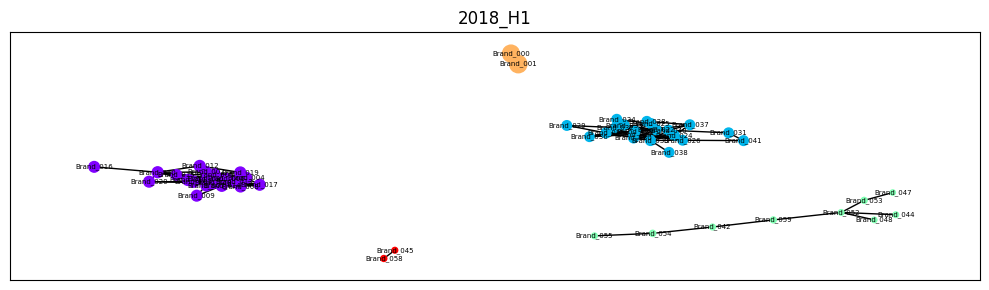

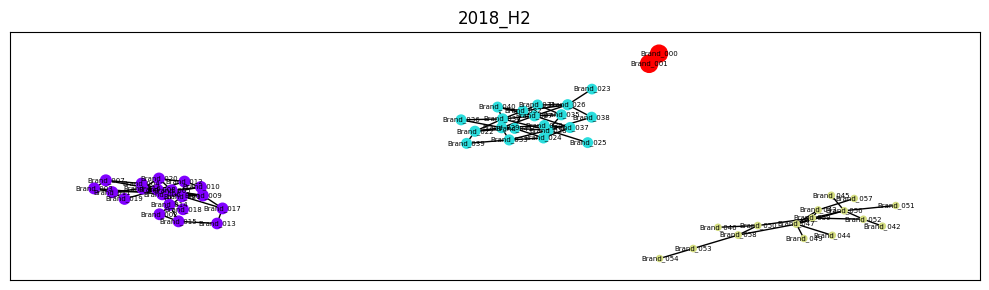

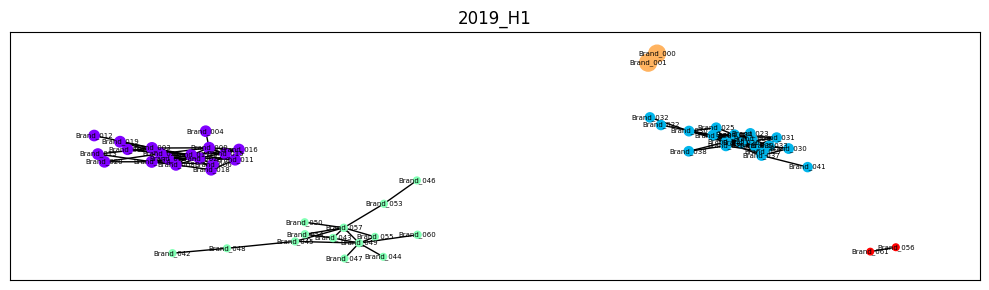

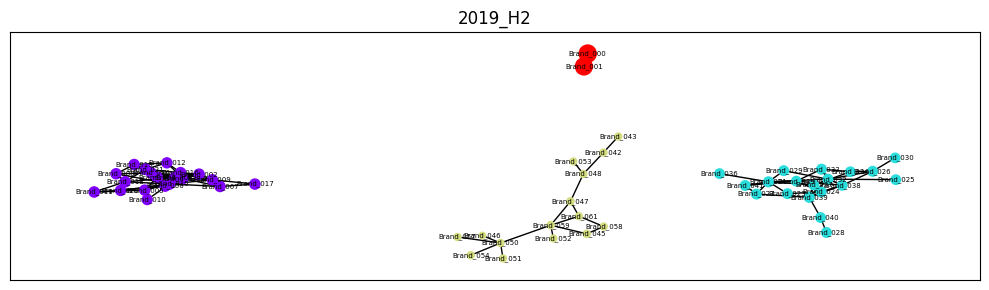

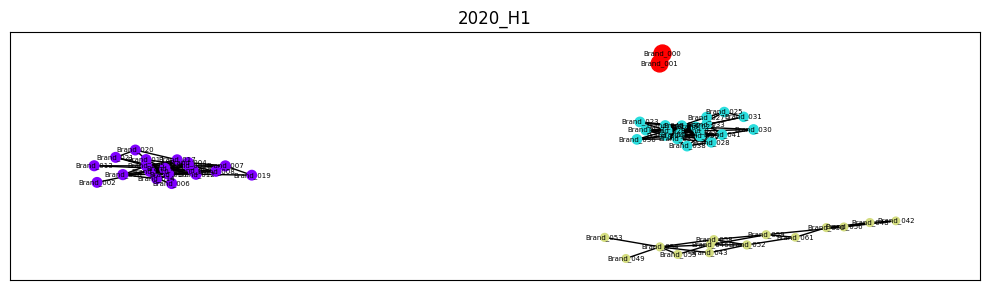

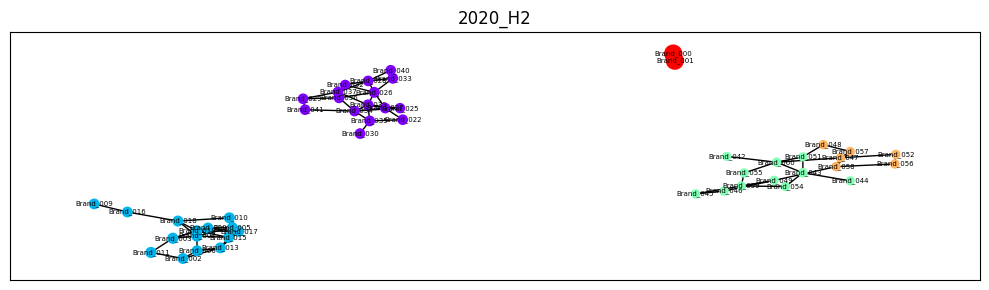

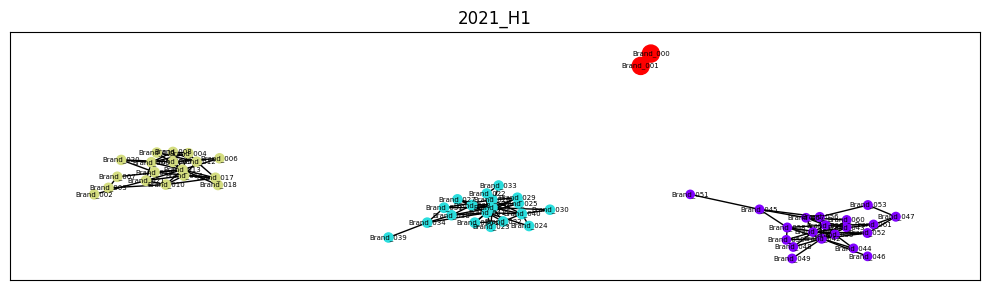

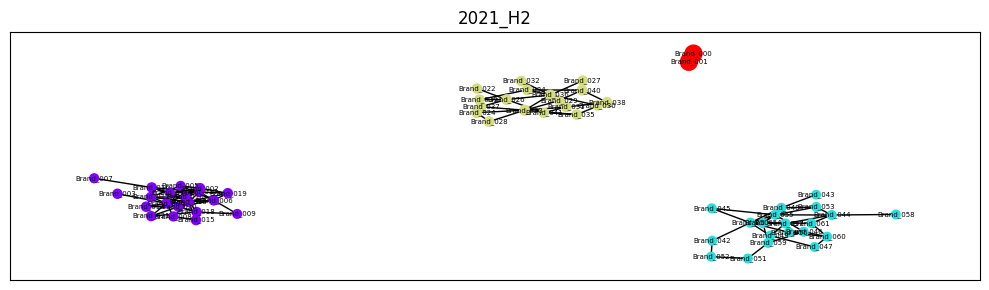

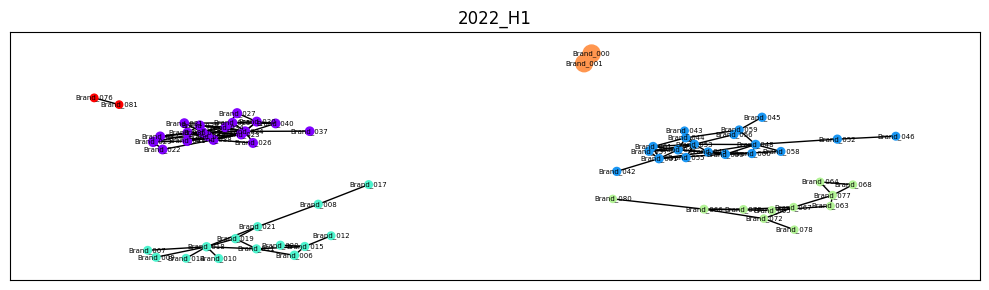

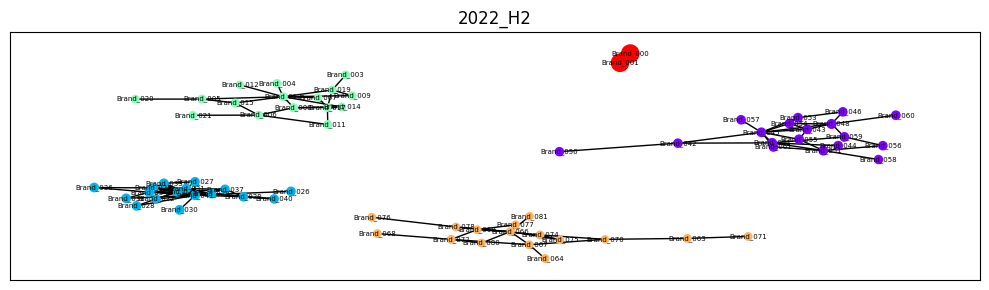

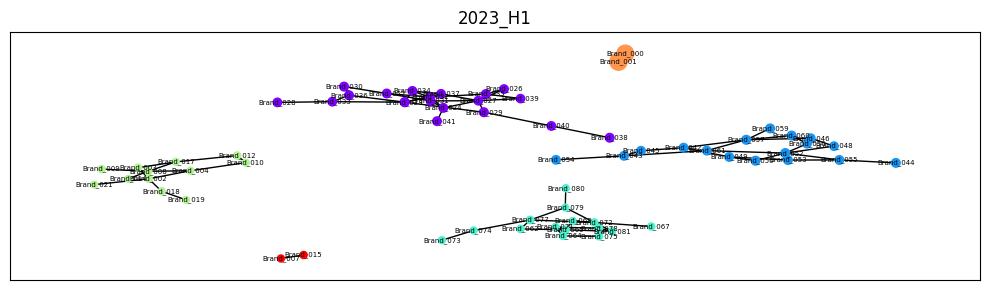

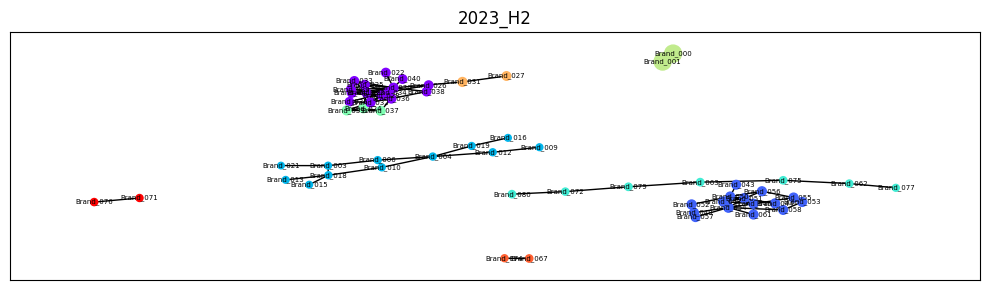

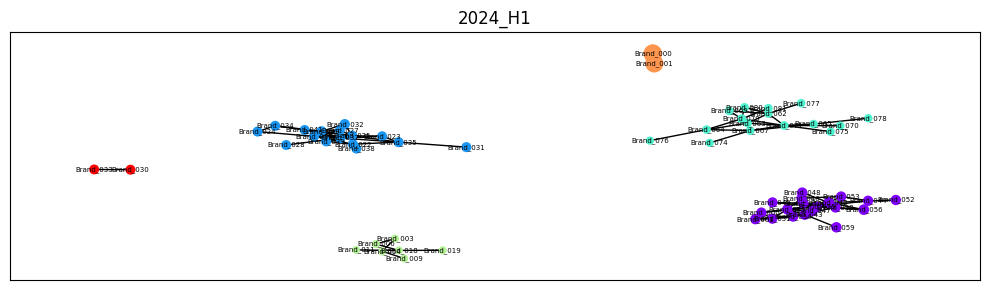

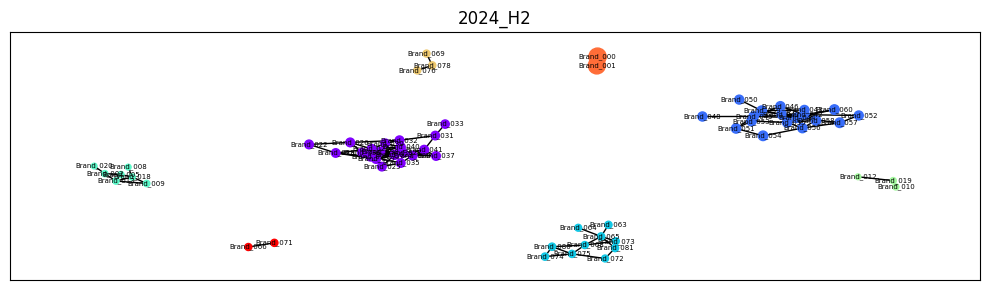

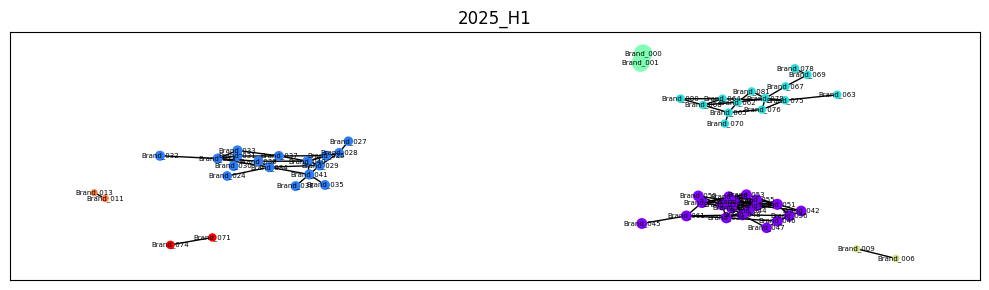

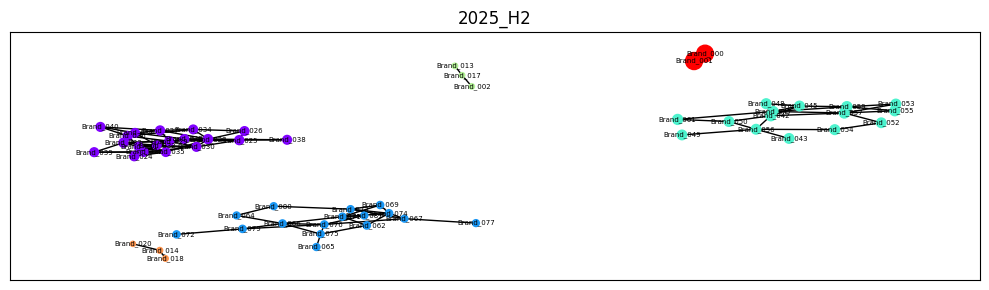

In [4]:
for period in TCT.period_list:
    TCT.plot_network(period, min_community_size=2,
                    figsize=(10, 3), plt_size=3, font_size=5, title=period)

## 動的分析
各コミュニティの継続・発生・消失を特定。

In [5]:
TCT.dynamic_analysis(threshold=0.2)

[Info] Processing Period: 2018_H1 (1/16) ---
[Info]   -> Found 52 initial communities.
[Info] Processing Period: 2018_H2 (2/16) ---
[Info]   - Match found: community_0 -> Current community 0 (Jaccard: 1.00)
[Info]   - Match found: community_1 -> Current community 1 (Jaccard: 1.00)
[Info]   - Match found: community_2 -> Current community 2 (Jaccard: 0.39)
[Info]   - Match found: community_3 -> Current community 3 (Jaccard: 1.00)
[Info]   - Match found: community_12 -> Current community 6 (Jaccard: 1.00)
[Info]   - Match found: community_13 -> Current community 7 (Jaccard: 1.00)
[Info]   - Match found: community_14 -> Current community 8 (Jaccard: 1.00)
[Info]   - Match found: community_15 -> Current community 9 (Jaccard: 1.00)
[Info]   - Match found: community_16 -> Current community 10 (Jaccard: 1.00)
[Info]   - Match found: community_17 -> Current community 11 (Jaccard: 1.00)
[Info]   - Match found: community_18 -> Current community 12 (Jaccard: 1.00)
[Info]   - Match found: community

In [6]:
display(TCT.df_volume_result.head())   
display(TCT.df_items_result.head())

community_id,community_0,community_1,community_10,community_100,community_101,community_102,community_103,community_104,community_105,community_106,...,community_90,community_91,community_92,community_93,community_94,community_95,community_96,community_97,community_98,community_99
period,,,,,,,,,,,,,,,,,,,,,
2018_H1,12229.0,9801.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_H2,11621.0,9673.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019_H1,10757.0,8745.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019_H2,10730.0,8989.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020_H1,9964.0,9261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,community_id,community_name,period,imte_count,items
0,0,community_0,2018_H1,20,"Brand_002, Brand_003, Brand_004, Brand_005, Br..."
1,1,community_1,2018_H1,20,"Brand_022, Brand_023, Brand_024, Brand_025, Br..."
2,2,community_2,2018_H1,9,"Brand_042, Brand_044, Brand_047, Brand_048, Br..."
3,3,community_3,2018_H1,2,"Brand_000, Brand_001"
4,4,community_4,2018_H1,2,"Brand_045, Brand_058"


推移を可視化

平均アイテム数が多い上位10件のコミュニティ: 
['community_1', 'community_0', 'community_2', 'community_87', 'community_156', 'community_69', 'community_126', 'community_157', 'community_4', 'community_3']


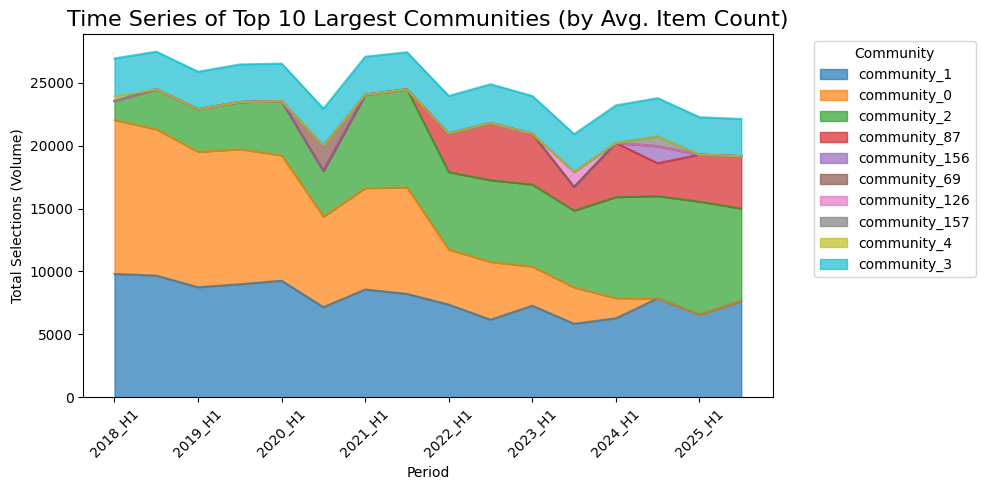

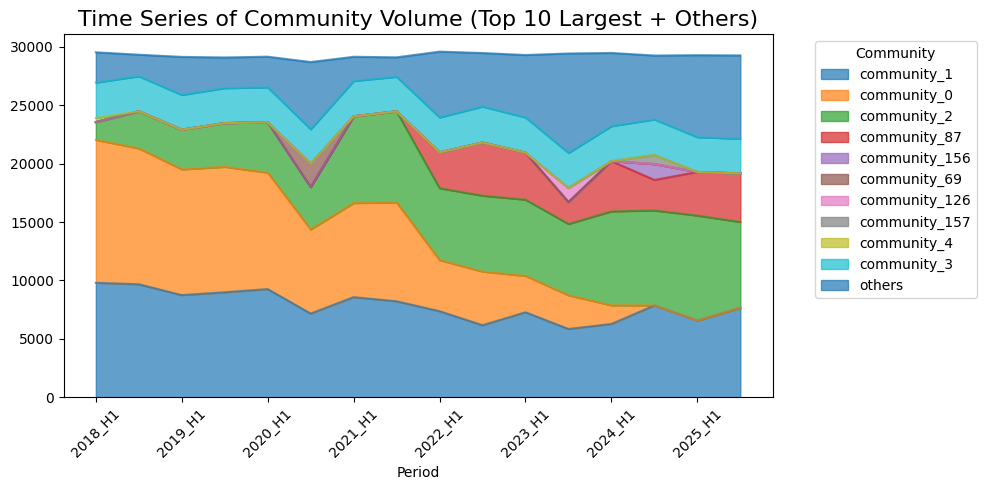

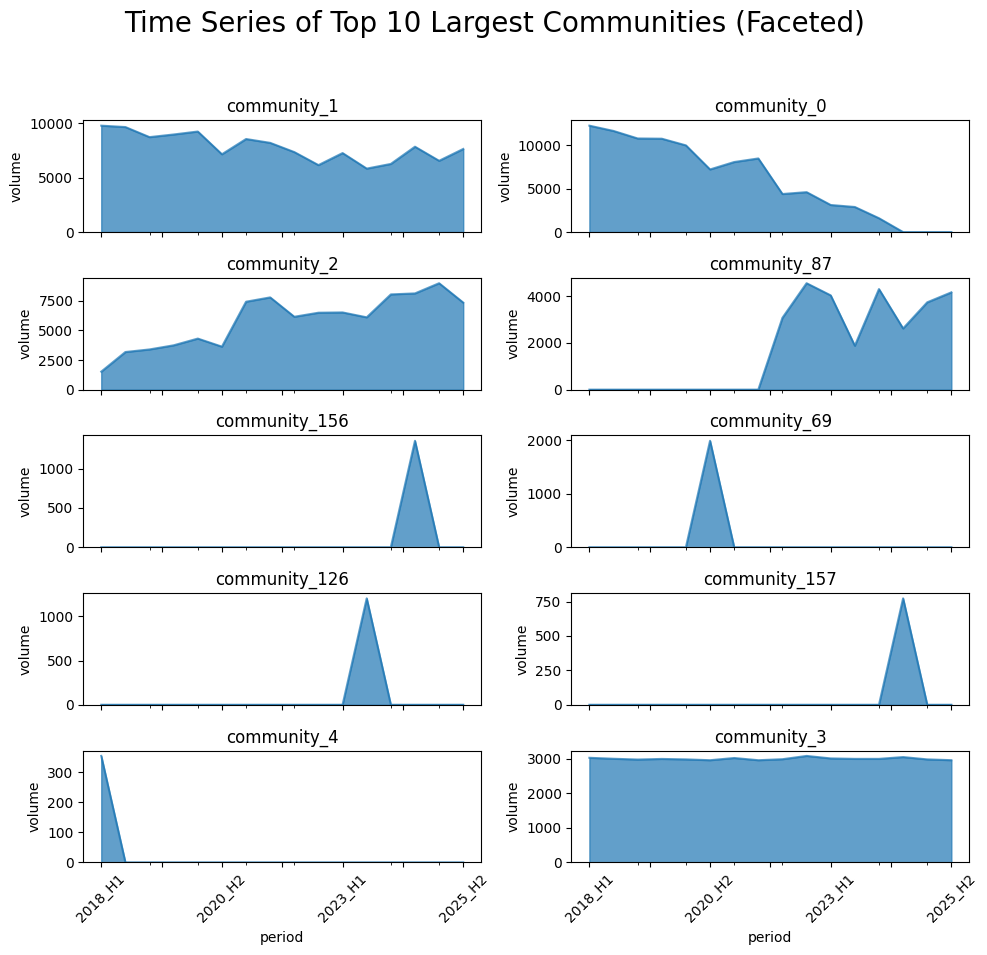

In [7]:
# 表示する上位Nコミュニティをしてい
N = 10 

# データ準備
item_avg_sizes = {}
for cid, info in TCT.tracked_communities.items():
    # 各期間のアイテム数をリストに格納
    period_sizes = [len(brands) for brands in info['history'].values()]
    # 平均アイテム数を計算
    if period_sizes:
        item_avg_sizes[info['name']] = np.mean(period_sizes)
# 平均アイテム数が多い順に並べたSeriesを作成
avg_size_series = pd.Series(item_avg_sizes).sort_values(ascending=False)
top_n_by_size = avg_size_series.head(N).index.tolist()
print(f"平均アイテム数が多い上位{N}件のコミュニティ: \n{top_n_by_size}")
df_topN_by_size = TCT.df_volume_result[top_n_by_size]

# グラフ描画
fig, ax = plt.subplots(figsize=(10, 5))
df_topN_by_size.plot(kind='area', stacked=True, ax=ax, alpha=0.7)
ax.set_title(f'Time Series of Top {N} Largest Communities (by Avg. Item Count)', fontsize=16)
ax.set_xlabel('Period')
ax.set_ylabel('Total Selections (Volume)')
ax.legend(title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 全体の中で上位N件以外を「その他」としてまとめる
other_communities = TCT.df_volume_result.columns.difference(top_n_by_size)
# 新しいデータフレームを作成
df_grouped_by_size = TCT.df_volume_result[top_n_by_size].copy()
df_grouped_by_size['others'] = TCT.df_volume_result[other_communities].sum(axis=1)

# グラフ描画
fig, ax = plt.subplots(figsize=(10, 5))
df_grouped_by_size.plot(kind='area', stacked=True, ax=ax, alpha=0.7)
ax.set_title(f'Time Series of Community Volume (Top {N} Largest + Others)', fontsize=16)
ax.set_xlabel('Period')
ax.legend(title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3x3のグリッドでグラフを複数描画
fig, axes = plt.subplots(5, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()
for i, worldview in enumerate(df_topN_by_size.columns):  # 上位9件のみ表示
    ax = axes[i]
    df_topN_by_size[worldview].plot(kind='area', ax=ax, alpha=0.7, title=worldview)
    ax.set_ylabel('volume')
    ax.tick_params(axis='x', rotation=45)
# 不要なサブプロットを非表示にする
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle(f'Time Series of Top {N} Largest Communities (Faceted)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()